In [1]:
import pandas as pd
import os 
from pathlib import Path
from bertopic import BERTopic
import re 
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display
import plotly.io as pio

import pandas as pd
import os 
from pathlib import Path
from nltk.corpus import stopwords

from preprocessing.preprocessing_module import full_cleaning_pipeline


metaproject_name = 'TopicModelling_META'
subproject_name = 'TopMod_pipeline'
# dataset_name = f'{condition}_dataset.csv'


dataset_name = "SensoryTool_CombinedData.csv"
HIGH_SENSORY = True #If False, corresponds to deep listening experience (no flicker)
condition = 'highsensory' if HIGH_SENSORY else 'deeplistening'
print(f'Condition : "{condition}"')




PROJDIR = os.path.expanduser(f"~/projects/{metaproject_name}")
DATADIR = os.path.join(PROJDIR,f'DATA/{dataset_name}')
CODEDIR = os.path.join(PROJDIR,f'{subproject_name}')



%matplotlib inline

/Users/rb666/projects/TopicModelling_META/topmodvenv/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/rb666/projects/TopicModelling_META/topmodvenv/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/rb666/projects/TopicModelli

Condition : "highsensory"


[nltk_data] Downloading package stopwords to /Users/rb666/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Parameters for BERTopic

https://maartengr.github.io/BERTopic/getting_started/embeddings/embeddings.html

In [2]:
from transformers.pipelines import pipeline

#Parameters for Topic Modelling
remove_stopwords = True
extended_stopwords = False

embedding_model = "all-MiniLM-L6-v2" #which transformer-based model to use to create embeddings of the reports
# embedding_model = pipeline("feature-extraction", model="distilbert-base-cased")
# topic_model = BERTopic(embedding_model=embedding_model)
min_topic_size = 10 #sets the minimum number of reports that a topic should have



Import Data

In [3]:
save_csv = False

df = pd.read_csv(DATADIR)
dataset = df[df['meta_HighSensory'] == HIGH_SENSORY]['reflection_answer']
reports = dataset[dataset.notna() & (dataset != '')].reset_index(drop=True)
reports = pd.DataFrame(reports)

reports = full_cleaning_pipeline(reports, 'reflection_answer')
reports = reports.reset_index(drop=True)

print('N={} reports (HighSensory = {})'.format(len(reports),HIGH_SENSORY))
reports.head()

# Save the cleaned data
if save_csv:
    base_name, ext = os.path.splitext(DATASET_NAME)
    new_path = f"{base_name}_preprocessed{ext}"
    preproc_path = os.path.join(PROJDIR, f'DATA/preprocessed/{new_path}')
    df_clean.to_csv(preproc_path, index=False)

/var/folders/1d/q_0fy53s0jdcsc1sb09wkntw00z7v7/T/ipykernel_47727/68989356.py:3: DtypeWarning: Columns (23,24,71,73,75,77,109,111,112,113,114,115,116,117,118,119,120,121,122,123,124,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,157,159,161,165,168,196,203,205) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATADIR)


N=307 reports (HighSensory = True)


## BERTopic

https://miro.medium.com/v2/resize:fit:4800/format:webp/0*DxAqCqx6dzg0KQlg.png

### Training the BERT model

In [4]:
from bertopic import BERTopic

model = BERTopic(language="english", calculate_probabilities=True, verbose=True,nr_topics='auto',embedding_model=embedding_model,min_topic_size=10) #The higher the value of min_topic_size, the more specific the topics will be
topics, probs = model.fit_transform(reports['reflection_answer']) #Fit model to data : topics are the topic labels for each document, probs are the probabilities of each topic for each document
model.visualize_topics() #Visualize topics


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

2023-10-03 16:53:30,066 - BERTopic - Transformed documents to Embeddings
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2023-10-03 16:53:32,987 - BERTopic - Reduced dimensionality
2023-10-03 16:53:32,998 - BERTopic - Clustered reduced embeddings
2023-10-03 16:53:33,017 - BERTopic - Reduced number of topics from 7 to 7


### Topic extraction and representation

In [5]:
topic_freq = model.get_topic_freq().head() #Get the frequency of each topic
freq = model.get_topic_info() #see the most representative terms for each topic
print("N number of topics: ",len(freq))
print(freq.head())


N number of topics:  7
   Topic  Count                                    Name  \
0     -1    159             -1_felt_like_experience_saw   
1      0     69               0_like_colours_shapes_saw   
2      1     32  1_experience_people_sometimes_thoughts   
3      2     13           2_music_sensation_yet_intense   
4      3     13         3_peace_peaceful_year_happiness   

                                      Representation  \
0  [felt, like, experience, saw, time, music, spa...   
1  [like, colours, shapes, saw, one, patterns, co...   
2  [experience, people, sometimes, thoughts, felt...   
3  [music, sensation, yet, intense, feel, relaxin...   
4  [peace, peaceful, year, happiness, self, sense...   

                                 Representative_Docs  
0  [It first settling lights flashing like kaledi...  
1  [Mainly stressed moments calm went dark blue s...  
2  [also experienced ghost people purifferal vers...  
3  [heard various music patterns different speed ...  
4  [spoke 

## Prileminary visualisation

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


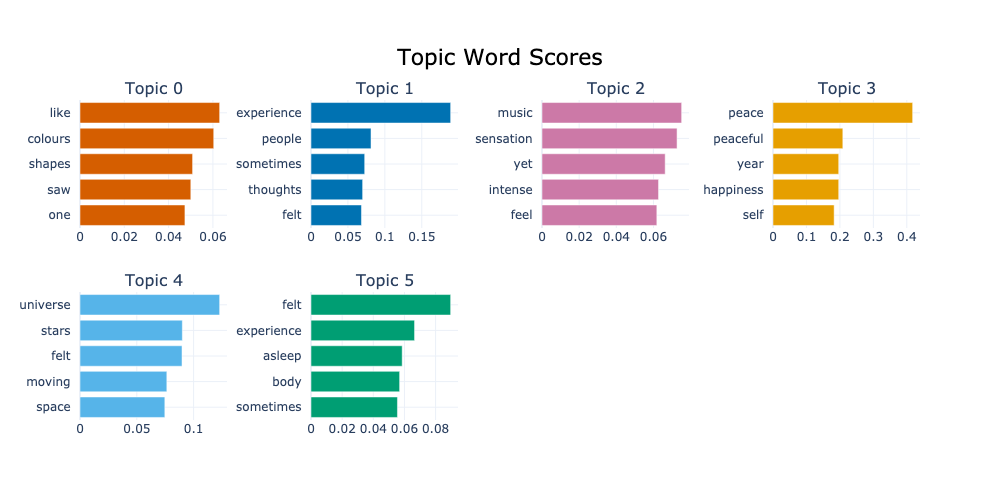

In [6]:
outputs_path = os.path.join(CODEDIR,'BERT_outputs')

# Save the barchart visualization to a file
fig = model.visualize_barchart(top_n_topics=10) #Visualize the top 10 topics
save_path_barchart = os.path.join(outputs_path,'BERT_barchart.png')
fig.write_image(save_path_barchart)

# # Import the Image and display functions from IPython
# from IPython.display import Image, display

# Display the saved image
display(Image(filename=save_path_barchart))

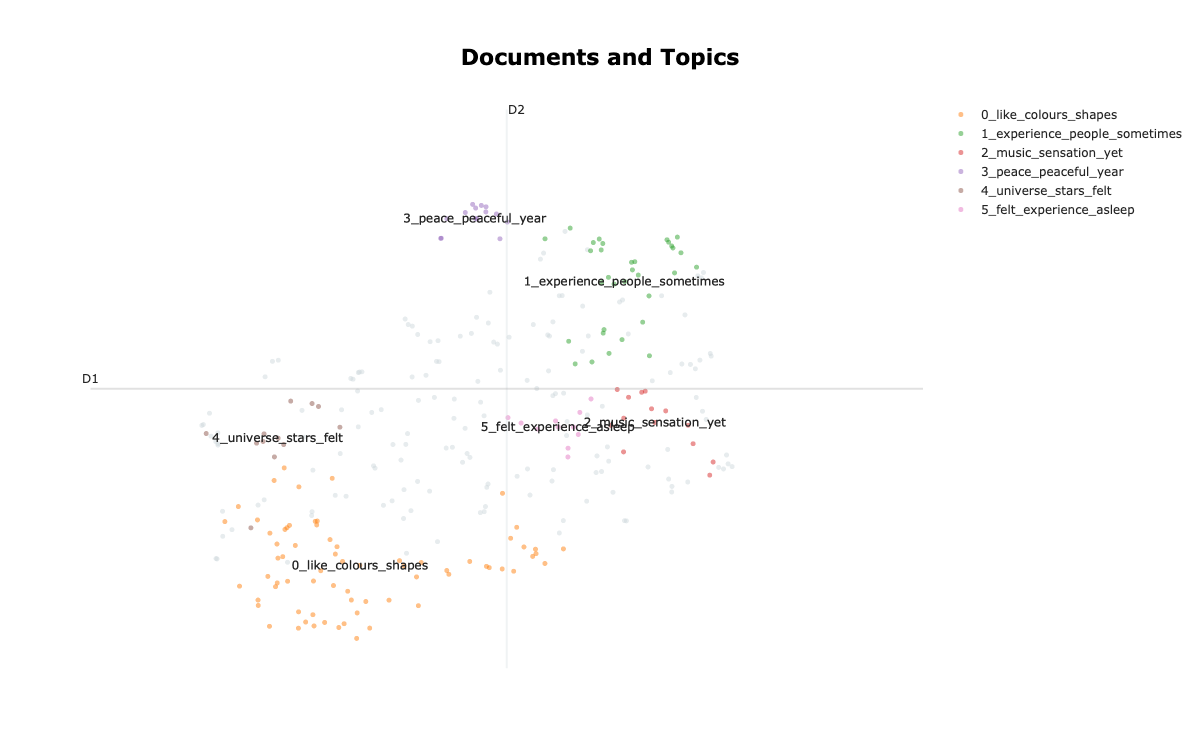

In [7]:
# Save the barchart visualization to a file
fig = model.visualize_documents(reports['reflection_answer'])
save_path_cloud = os.path.join(outputs_path,'BERT_cloud_{}.png'.format(condition))
fig.write_image(save_path_cloud)

# # Import the Image and display functions from IPython
# from IPython.display import Image, display

# Display the saved image
display(Image(filename=save_path_cloud))

In [8]:
model.visualize_heatmap(top_n_topics=10) #Visualize the top 10 topics as a heatmap